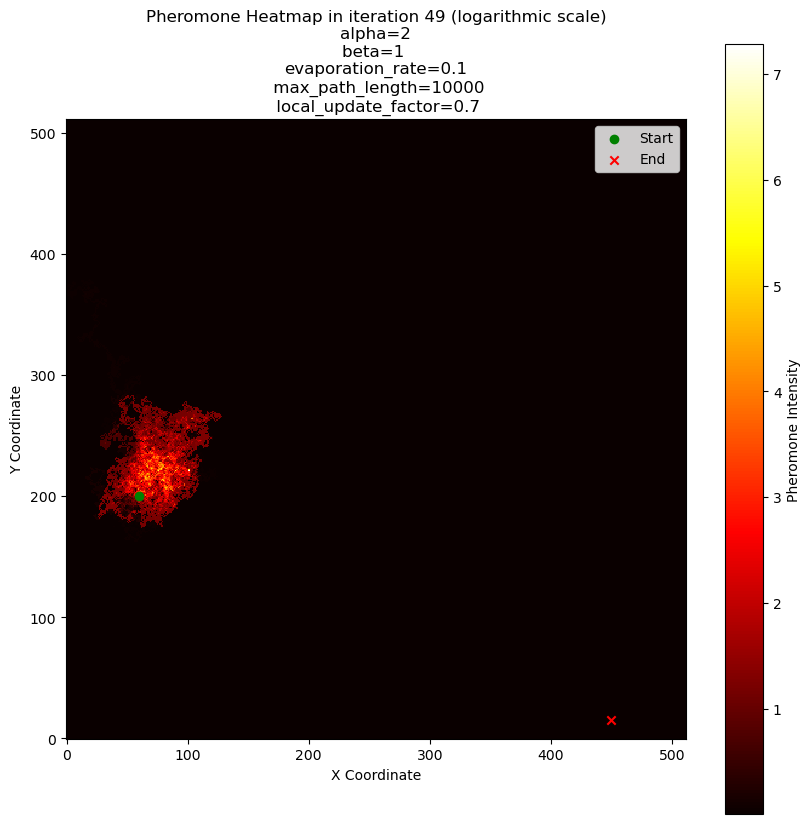

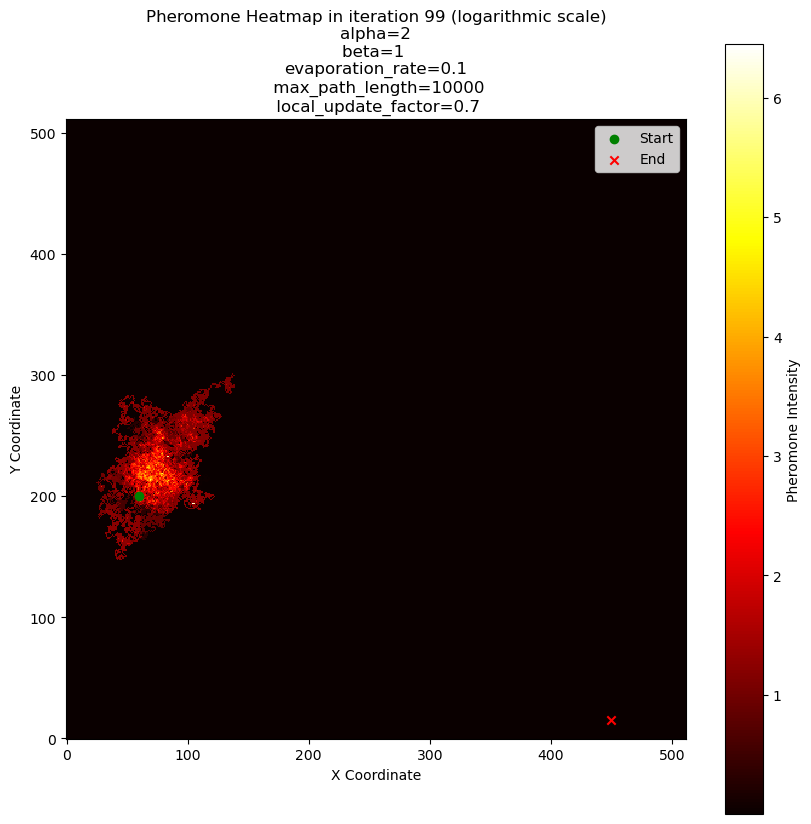

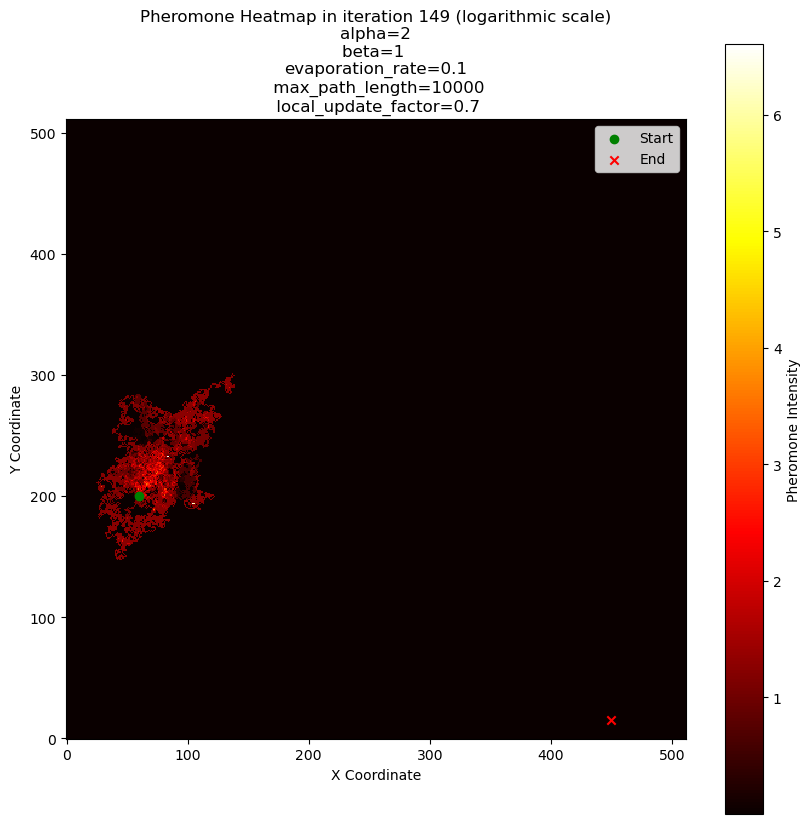

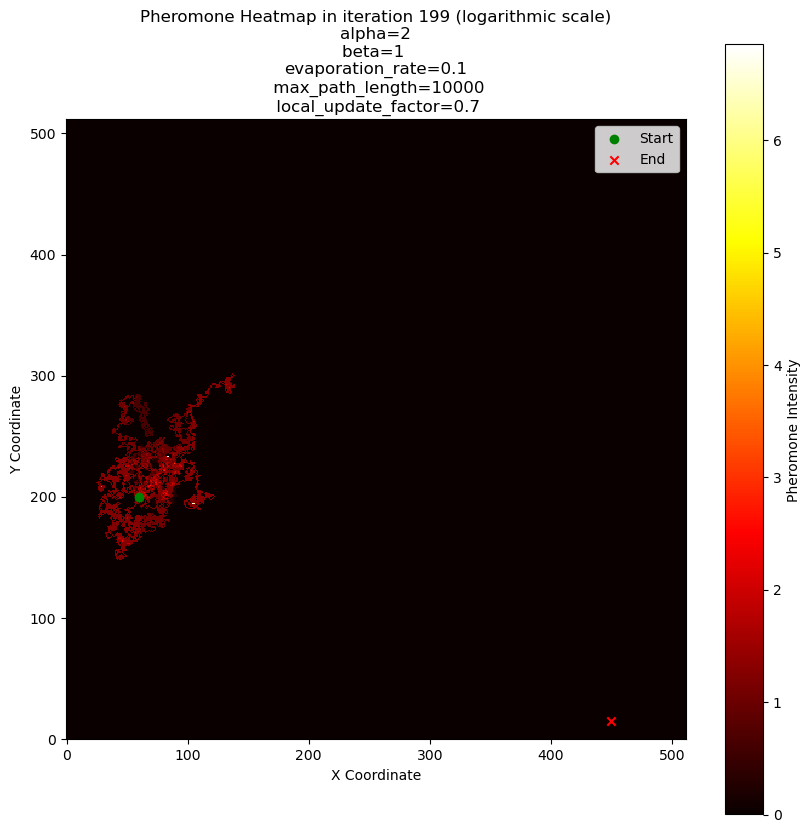

Best path energy: 160.02393638636838
Path length: 10000
Path: [(60, 200), (59, 201), (59, 200), (60, 201), (60, 202), (59, 202), (59, 203), (60, 203), (60, 204), (59, 204)]...


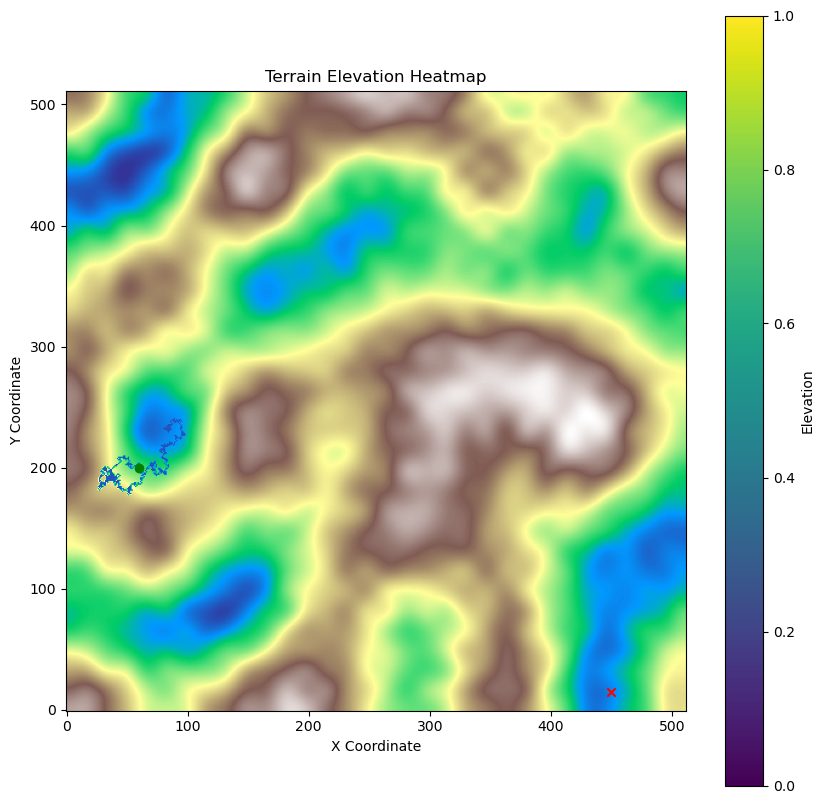

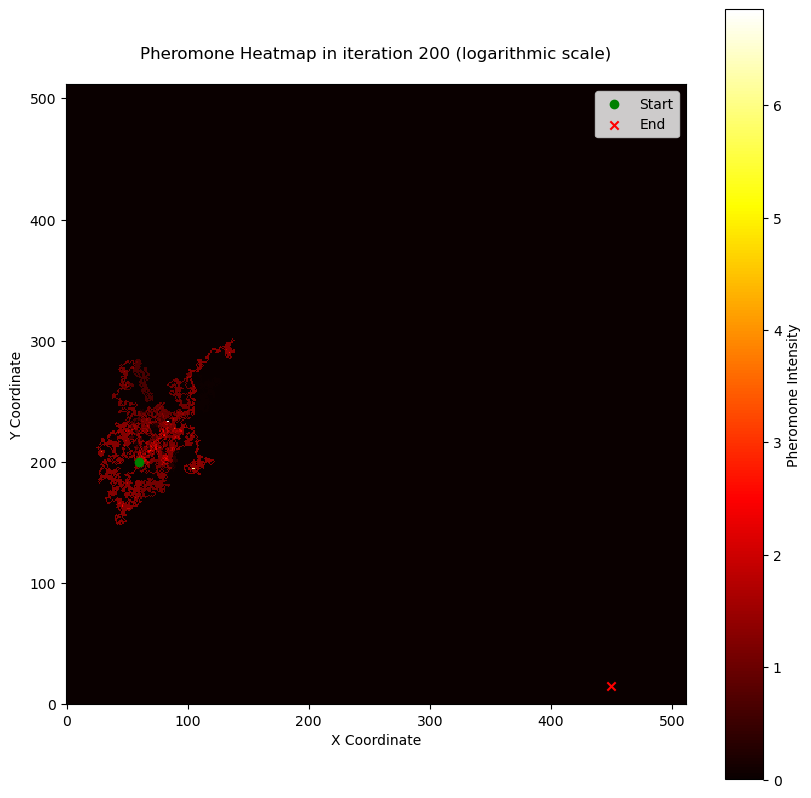

In [1]:
import re
import numpy as np
import random
import matplotlib.pyplot as plt


import matplotlib.animation as animation
from soupsieve import closest
from sympy import false
from tables import Description


def load_start_end_points(filename):
    with open(filename, "r") as file:
        start = tuple(map(int, file.readline().split()))
        end = tuple(map(int, file.readline().split()))
    return start, end


def load_terrain_data(filename):
    data = np.loadtxt(filename, delimiter=" ")
    terrain = {(int(x), int(y)): {"z": z, "bonus_penalty": b} for x, y, z, b in data}
    return terrain


def calculate_energy(x1, y1, z1, x2, y2, z2, b):
    d = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2 + (z2 - z1) ** 2)
    energy = 0.2 * d + 0.1 * (z2 - z1)
    if b == 1:  # Bonus
        energy -= 5
    elif b == -1:  # Penalty
        energy += 10
    return max(energy, 0)


class Ant:
    def __init__(self, start_pos):
        self.pos = start_pos
        self.energy_used = 0
        self.path = [start_pos]
        self.visited = {start_pos} 

    def move(self, terrain, next_pos):
        current_info = terrain[self.pos]
        next_info = terrain[next_pos]
        energy = calculate_energy(
            *self.pos,
            current_info["z"],
            *next_pos,
            next_info["z"],
            next_info["bonus_penalty"],
        )
        self.energy_used += energy
        self.pos = next_pos
        self.path.append(next_pos)
        self.visited.add(next_pos)

    def reset(self, start_pos):
        self.pos = start_pos
        self.energy_used = 0
        self.path = [start_pos]
        self.visited.clear()  # Ezt a set-et újrainicializáljuk helyett töröljük a tartalmát
        self.visited.add(start_pos)


def get_neighbors(pos, terrain):
    x, y = pos
    neighbors = []
    for dx in [-1, 0, 1]:
        for dy in [-1, 0, 1]:
            if dx == 0 and dy == 0:
                continue
            neighbor = (x + dx, y + dy)
            if neighbor in terrain:
                neighbors.append(neighbor)
    return neighbors


def heuristic_distance(current_pos, next_pos, end):
    # Calculate the straight-line distance from the next_pos to the end
    return np.sqrt((end[0] - next_pos[0]) ** 2 + (end[1] - next_pos[1]) ** 2)


def heuristic_energy(terrain, current_pos, next_pos):
    current_info = terrain[current_pos]
    next_info = terrain[next_pos]
    d = np.sqrt(
        (next_pos[0] - current_pos[0]) ** 2 + (next_pos[1] - current_pos[1]) ** 2
    )
    energy = 0.2 * d + 0.1 * (next_info["z"] - current_info["z"])
    # Bonus or penalty
    if next_info["bonus_penalty"] == 1:
        energy -= 5
    elif next_info["bonus_penalty"] == -1:
        energy += 10
    return 1 / (1 + energy)  # Convert energy requirement to heuristic value


def choose_next_node(ant, terrain, pheromones, end, alpha, beta):
    current_pos = ant.pos
    neighbors = get_neighbors(current_pos, terrain)
    filtered_neighbors = [n for n in neighbors if n not in ant.visited]

    if not filtered_neighbors:
        return ant.path[-2]  # Return to the previous node if all neighbors have been visited   

    probabilities = []
    for neighbor in filtered_neighbors:
        tau_ij = pheromones.get((current_pos, neighbor), 0.1)
        eta_ij = heuristic_energy(terrain, current_pos, neighbor)
        probabilities.append(tau_ij**alpha * eta_ij**beta)

    if sum(probabilities) == 0:
        return random.choice(filtered_neighbors)

    probabilities = [
        p / sum(probabilities) for p in probabilities
    ] 
    next_node = random.choices(filtered_neighbors, weights=probabilities, k=1)[0]
    return next_node


def initialize_pheromones(terrain):
    pheromones = {}
    for (x, y), _ in terrain.items():
        neighbors = get_neighbors((x, y), terrain)
        for neighbor in neighbors:
            pheromones[((x, y), neighbor)] = 0.1  # Initial small positive value
    return pheromones


def reinforce_path(pheromones, path, energy, reinforce_factor, end_path=False):
    if end_path:
        print("path found: ", path, "energy: ", energy, "reinforce_factor: ", reinforce_factor)
    for i in range(len(path) - 1):
        edge = (path[i], path[i + 1])
        pheromones[edge] += (1 / (energy + 1e-6)) * reinforce_factor


def local_pheromone_update(pheromones, path, local_pheromone_increase):
    for i in range(len(path) - 1):
        edge = (path[i], path[i + 1])
        pheromones[edge] *= (
            1 - local_pheromone_increase
        )  # Evaporate the existing pheromone slightly
        pheromones[edge] += local_pheromone_increase


def global_pheromone_update(pheromones, best_path, evaporation_rate):
    for edge in pheromones:
        pheromones[edge] *= 1 - evaporation_rate

    # Add new pheromones on the global best path
    # F(s) = 1 / L_k where L_k is the energy of the best path
    additional_pheromone = 1 / (best_path["energy"] + 1e-6)  # to avoid division by zero
    for i in range(len(best_path["path"]) - 1):
        edge = (best_path["path"][i], best_path["path"][i + 1])
        pheromones[edge] += additional_pheromone * evaporation_rate  # Multiply by evaporation_rate to simulate the summation of pheromone over all ants as per the formula.


def remove_loops(path):
    """
    Removes all loops from the path to potentially lower the energy cost.
    A loop is defined as any sequence where the same node appears more than once.
    The function retains the first occurrence of the node and removes the loop by
    connecting it directly to the node after the second occurrence of the loop.
    """
    path_index = {}  # Stores indices of each node
    new_path = []  # New path without loops

    for i, node in enumerate(path):
        if node in path_index:
            loop_start = path_index[node]
            new_path = new_path[: loop_start + 1]
            if loop_start < len(new_path) - 1:
                new_path.append(path[i])
        else:
            new_path.append(node)
        path_index[node] = i  # Update the index of the current node

    return new_path


def daemon_actions(ants, pheromones, evaporation_rate, terrain, end):
    # find closest path to the end point
    closest_path = min(ants, key=lambda a: heuristic_distance(None, a.pos, end))
    # reinforce paths closer to the global best path
    reinforce_path(pheromones, closest_path.path, closest_path.energy_used, 4)
    for ant in ants:
        optimized_path = remove_loops(ant.path)
        ant.path = optimized_path
        ant.energy_used = calculate_total_energy(
            terrain, ant.path
        ) 


def calculate_total_energy(terrain, path):
    """
    Calculate the total energy used for a given path.
    """
    total_energy = 0
    for i in range(len(path) - 1):
        start_node = path[i]
        end_node = path[i + 1]
        start_info = terrain[start_node]
        end_info = terrain[end_node]
        energy = calculate_energy(
            *start_node,
            start_info["z"],
            *end_node,
            end_info["z"],
            end_info["bonus_penalty"],
        )
        total_energy += energy
    return total_energy


def aco_search(
    terrain,
    start,
    end,
    num_ants=10,
    iterations=50,
    initial_alpha=1,
    initial_beta=1,
    evaporation_rate=0.5,
    max_path_length=500,
    local_update_factor=0.1,
):
    pheromones = initialize_pheromones(terrain)
    best_path = {"path": None, "energy": float("inf")}

    ants = [Ant(start) for _ in range(num_ants)]

    # boolean to check if the path has converged
    convergedFinal = False
    alpha = initial_alpha
    beta = initial_beta

    for iteration in range(iterations):

        # switch between exploration and exploitation in quarter iterations
        # if iteration in [iterations/4-1, iterations/2-1, 3*iterations/4-1, iterations-1]:
        #     alpha, beta = beta, alpha
        # if iteration < iterations/4:
        #     alpha = initial_alpha
        #     beta = initial_beta
        # elif iteration < iterations/2:
        #     alpha = initial_alpha*2
        #     beta = initial_beta/2
        # elif iteration < 3*iterations/4:
        #     alpha = initial_alpha*2
        #     beta = initial_beta*2
        # else:
        #     alpha = alpha*2
        #     beta = initial_beta/4

        for path, energy_used, converged in generate_paths(
            ants, terrain, pheromones, start, end, alpha, beta, max_path_length, local_update_factor
        ):
            if converged:
                if not convergedFinal:
                    best_path["path"] = path
                    best_path["energy"] = energy_used
                    reinforce_path(pheromones, path, energy_used, 7)
                convergedFinal = True

            if not convergedFinal:
                if energy_used < best_path["energy"]:
                    best_path["path"] = path
                    best_path["energy"] = energy_used
            else:
                if energy_used < best_path["energy"]:
                    best_path["path"] = path
                    best_path["energy"] = energy_used
                    reinforce_path(pheromones, path, energy_used, 10, True)

        daemon_actions(ants, pheromones, evaporation_rate, terrain, end)
        global_pheromone_update(pheromones, best_path, evaporation_rate)
        if iteration in [iterations/4-1, iterations/2-1, 3*iterations/4-1, iterations-1]: 
            description = f"alpha={alpha}\nbeta={beta} \nevaporation_rate={evaporation_rate}\n max_path_length={max_path_length}\n local_update_factor={local_update_factor}"
            plot_pheromone_map_in_four_iterations(pheromones, start, end, iteration, description=description)

    return best_path["path"], best_path["energy"], pheromones


def generate_paths(ants, terrain, pheromones,start, end, alpha, beta, max_path_length, local_update_factor):
    for ant in ants:
        ant.reset(start)  # Reset the ant for the new iteration
        while ant.pos != end and (max_path_length==0 or len(ant.path) < max_path_length):
            next_pos = choose_next_node(ant, terrain, pheromones, end, alpha, beta)
            ant.move(terrain, next_pos)
            local_pheromone_update(pheromones, ant.path[-2:], local_update_factor)
        yield ant.path, ant.energy_used, ant.pos==end


def plot_pheromone_map_in_four_iterations(pheromones, start, end, i, description=""):
    pheromone_map = np.zeros((512,512))  # Assuming a 512x512 terrain

    # logarithmic scale
    for ((x1, y1), (x2, y2)), intensity in pheromones.items():
        pheromone_map[x1, y1] += np.log(intensity + 1)
        pheromone_map[x2, y2] += np.log(intensity + 1)

    plt.figure(figsize=(10, 10))
    plt.imshow(pheromone_map.T, origin="lower", cmap="hot", interpolation="nearest")
    plt.colorbar(label="Pheromone Intensity")
    plt.scatter(*start, c="green", marker="o", label="Start")
    plt.scatter(*end, c="red", marker="x", label="End")
    plt.title(f"Pheromone Heatmap in iteration {i} (logarithmic scale)\n{description}")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.legend()
    plt.show()


def plot_terrain_heatmap(terrain, start, end, best_path):
    max_x = max(pos[0] for pos in terrain.keys()) + 1
    max_y = max(pos[1] for pos in terrain.keys()) + 1
    heatmap = np.zeros((max_x, max_y))

    for (x, y), info in terrain.items():
        heatmap[x, y] = info["z"]

    # Plot the best path on the heatmap
    for x, y in best_path:
        heatmap[x, y] = 1

    plt.figure(figsize=(10, 10))
    plt.imshow(heatmap.T, origin="lower", cmap="terrain")

    plt.scatter(*start, c="green", marker="o", label="Start")
    plt.scatter(*end, c="red", marker="x", label="End")

    plt.colorbar(label="Elevation")
    plt.title("Terrain Elevation Heatmap")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.show()


def main():
    terrain = load_terrain_data("aco_points_512x512.txt")
    start, end = load_start_end_points("aco_start_end_512x512.txt")

    best_path, energy, pheromones = aco_search(
        terrain,
        start,
        end,
        num_ants=10,
        iterations=200,
        initial_alpha=2,
        initial_beta=1,
        evaporation_rate=0.1,
        max_path_length=10000,
        local_update_factor=0.7,
    )

    print(
        f"Best path energy: {energy}\nPath length: {len(best_path)}\nPath: {best_path[:10]}..."
    )

    # Visualization 1: Heatmap of the field
    plot_terrain_heatmap(terrain, start, end, best_path)

    # Visualization 2: Pheromone map
    plot_pheromone_map_in_four_iterations(pheromones, start, end, 200)


if __name__ == "__main__":
    main()